In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *

In [3]:
import torch
from torch import nn

# Motif

In [5]:
dataset = MotifDataset(seed=12345)

data: Data(x=[20, 5], edge_index=[2, 52], y=[1], G=Graph named 'House Graph' with 20 nodes and 26 edges)
class: house


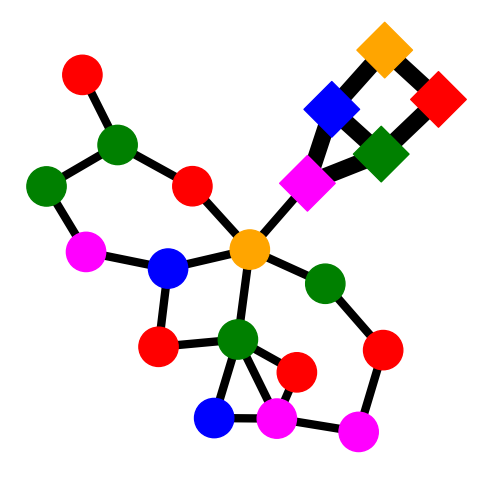

In [7]:
dataset.show(0)

In [6]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=64,
                      num_layers=3)

In [9]:
model.load_state_dict(torch.load('ckpts/motif.pt'))

<All keys matched successfully>

In [11]:
dataset.evaluate_model(model)

{'partial': 0.9914828538894653,
 'house': 0.995945930480957,
 'house_x': 0.9988998770713806,
 'comp_4': 0.9966791272163391,
 'comp_5': 1.0}

In [10]:
mean_embeds = dataset.mean_embeddings(model)

/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [18]:
trainer = {}
sampler = {}

# House

In [19]:
classes = 1
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_node_cls=len(dataset.NODE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=0), mode="maximize", weight=0.5),
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=1), mode="maximize", weight=1),
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=2), mode="maximize", weight=-0.5),
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=3), mode="maximize", weight=-0.5),
        # dict(key="logits", criterion=CrossEntropyBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=MeanSquareBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=DynamicBalancingCriterion(classes=classes), weight=5),
        # dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes[0]]), weight=10),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[1]), weight=1),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                  discriminator=model,
                  criterion=criterion,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  dataset=dataset,
                  k_samples=16)

In [20]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [21]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [22]:
trainer[1].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=14 m=15
logits=[8.010212898254395, 12.983661651611328, -16.276866912841797, -20.305919647216797, -21.189367294311523]
probs=[0.006871697027236223, 0.9931282997131348, 1.9467907104095405e-13, 3.4635693903326166e-15, 1.4316876982176877e-15]


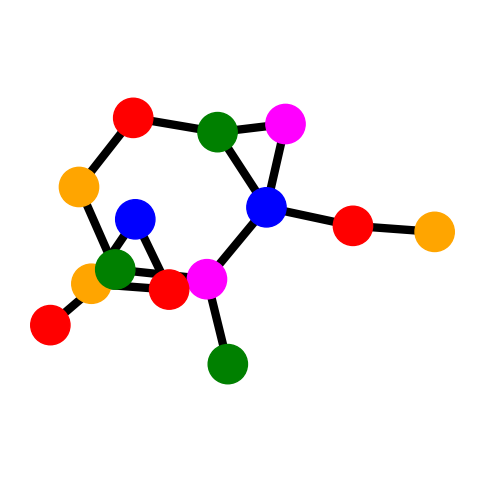

In [23]:
trainer[1].evaluate(threshold=0.5, show=True)

# House X

In [45]:
classes = 2
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_node_cls=len(dataset.NODE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=dataset,
                           k_samples=16)

In [46]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9

def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [48]:
trainer[2].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=11 m=14
logits=[10.12785816192627, -28.11570930480957, 18.187055587768555, -9.166486740112305, -14.25048542022705]
probs=[0.00031608054996468127, 7.777274096052175e-21, 0.9996839761734009, 1.3193810193684596e-12, 8.173672276393183e-15]


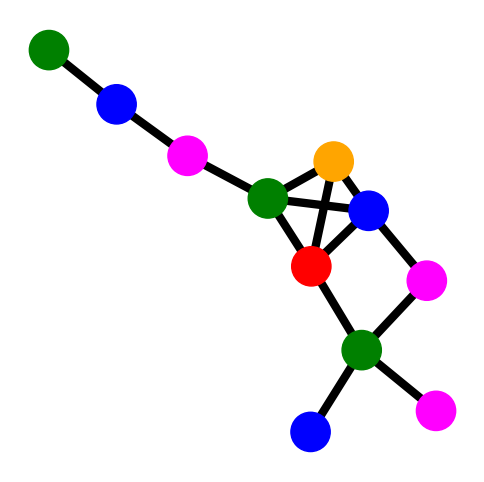

In [49]:
trainer[2].evaluate(threshold=0.5, show=True)

# Comp 4

In [51]:
classes = 3
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_node_cls=len(dataset.NODE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=dataset,
                           k_samples=16)

In [52]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9
    
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [54]:
trainer[3].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=13 m=15
logits=[16.50334358215332, -41.19040298461914, -16.474313735961914, 21.241636276245117, -41.53955841064453]
probs=[0.008677618578076363, 7.6265058757010564e-28, 4.134147454633056e-17, 0.99132239818573, 5.378828148874545e-28]


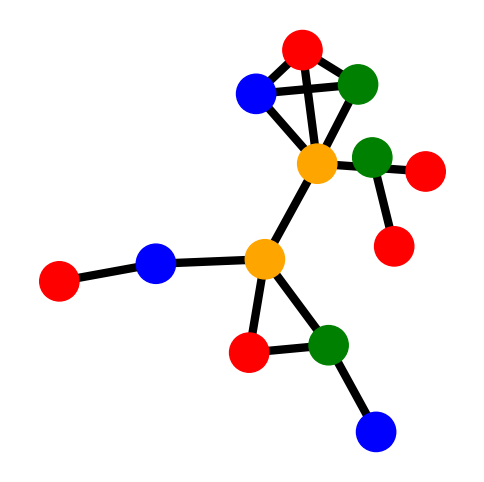

In [55]:
trainer[3].evaluate(threshold=0.5, show=True)

# Comp 5

In [68]:
classes = 4
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_node_cls=len(dataset.NODE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=dataset,
                           k_samples=16)

In [69]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9
    
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [70]:
trainer[4].train(5000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/5000 [00:00<?, ?it/s]

True

n=10 m=14
logits=[20.852563858032227, -40.37002944946289, -12.6128568649292, -44.95913314819336, 29.786319732666016]
probs=[0.00013184444105718285, 3.3995969008549225e-31, 3.8566825601311526e-19, 3.454657408895744e-33, 0.9998681545257568]


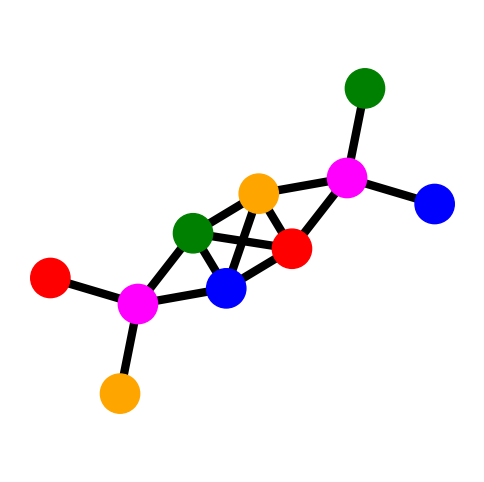

In [71]:
trainer[4].evaluate(threshold=0.5, show=True)